<a href="https://colab.research.google.com/github/kavi-910/Prefina_Recommendation_System/blob/main/ALS_Recommendation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Environment Setup

#Installing packages
!pip install --quiet \
  pandas numpy scikit-learn \
  lightfm implicit scipy \
  pyarrow tqdm ipywidgets

#Installing visualization tools
!pip install --quiet seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.9 MB/s eta 0:00:00


In [ ]:
#Setting random seed
import random, os, numpy as np
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
#Import Libraries & Configurations

#Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ML & Recommender
from lightfm import LightFM
from implicit.als import AlternatingLeastSquares

#Utility
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm

#Display settings for clean output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
tqdm.pandas()

In [ ]:
#Uploading datasets
from google.colab import files
import pandas as pd

uploaded = files.upload()

df_products = pd.read_csv('products_H&M.csv')
df_users = pd.read_csv('customers_H&M.csv')
df_interactions = pd.read_csv('customer_interactions_H&M.csv')

Saving customer_interactions_H&M.csv to customer_interactions_H&M.csv
Saving customers_H&M.csv to customers_H&M.csv
Saving products_H&M.csv to products_H&M.csv


In [ ]:
print("\n Products Shape: ", df_products.shape)
print("\n Products Sample:")
display(df_products.head())

print("\n Users Shape: ", df_users.shape)
print("\n Users Sample:")
display(df_users.head())

print("\n Interactions Shape: ", df_interactions.shape)
print("\n Interactions Sample:")
display(df_interactions.head())


 Products Shape:  (1100, 8)

 Products Sample:


,product_id,color,product_type,price,material,pattern,season,price_range
0,PID00001,black,coat,12329,polyester,solid,winter,10000-18000
1,PID00002,red,coat,15299,Compound,solid,spring,10000-18000
2,PID00003,black,coat,13094,polyester,solid,spring,10000-18000
3,PID00004,blue,coat,11369,nylon,solid,spring,10000-18000
4,PID00005,black,coat,10943,polyester,solid,spring,10000-18000



 Users Shape:  (300, 5)

 Users Sample:


,user_id,age,gender,preferred_size,branch
0,U0001,28,M,L,Colombo
1,U0002,18,F,L,Negombo
2,U0003,32,M,L,Colombo
3,U0004,29,M,L,Colombo
4,U0005,26,F,M,Colombo



 Interactions Shape:  (42533, 4)

 Interactions Sample:


,user_id,product_id,event_type,timestamp
0,U0001,PID00181,view,2025-04-11 06:30:00
1,U0001,PID00181,click,2025-04-11 06:30:00
2,U0001,PID00650,view,2025-05-07 02:17:00
3,U0001,PID00650,click,2025-05-07 02:17:00
4,U0001,PID00650,add_to_cart,2025-05-07 02:17:00


In [ ]:
#Data cleaning

# 1 - Strip(clear) whitespace and lowercase columns
df_products.columns = df_products.columns.str.strip().str.lower()
df_users.columns = df_users.columns.str.strip().str.lower()
df_interactions.columns = df_interactions.columns.str.strip().str.lower()

# 2 - Remove duplicate rows
df_products.drop_duplicates(inplace = True)
df_users.drop_duplicates(inplace = True)
df_interactions.drop_duplicates(inplace = True)

# 3 - Drop missing values
df_products.dropna(how='all', inplace = True)
df_users.dropna(how='all', inplace = True)
df_interactions.dropna(how='all', inplace = True)

# 4 Resetting indexes
df_products.reset_index(drop=True, inplace=True)
df_users.reset_index(drop=True, inplace=True)
df_interactions.reset_index(drop=True, inplace=True)

print("Products updated shape: ", df_products.shape)
print("Users updated shape: ", df_users.shape)
print("Interactions updated shape: ", df_interactions.shape)

Products updated shape:  (1100, 8)
Users updated shape:  (300, 5)
Interactions updated shape:  (42533, 4)


In [ ]:
# ── 1. Thin low-signal “view” rows to 5 % ──
event_weights = {
    "view": 1,
    "click": 2,
    "wishlist": 2.5,
    "add_to_cart": 3,
    "rating": 4,
    "purchase": 20      # boost purchase importance
}

views  = df_interactions[df_interactions["event_type"] == "view"]
non_v  = df_interactions[df_interactions["event_type"] != "view"]
views  = views.sample(frac=0.05, random_state=42)        # keep 5 %

df_interactions = (
    pd.concat([non_v, views], axis=0)
      .reset_index(drop=True)
)

# ── 2. Map event → weight (only once) ──
df_interactions["event_weight"] = df_interactions["event_type"].map(event_weights)

# ── 3. Filter users / items with at least 3 interactions ──
tmp = df_interactions[["user_id", "product_id"]]
good_users    = tmp["user_id"].value_counts()[lambda s: s >= 3].index
good_products = tmp["product_id"].value_counts()[lambda s: s >= 3].index

df_interactions = df_interactions[
    df_interactions["user_id"].isin(good_users) &
    df_interactions["product_id"].isin(good_products)
].reset_index(drop=True)

print("Rows after thinning & filtering:", len(df_interactions))
display(df_interactions.head())


Rows after thinning & filtering: 22198


,user_id,product_id,event_type,timestamp,event_weight
0,U0001,PID00181,click,2025-04-11 06:30:00,2.0
1,U0001,PID00650,click,2025-05-07 02:17:00,2.0
2,U0001,PID00650,add_to_cart,2025-05-07 02:17:00,3.0
3,U0001,PID00650,rating,2025-05-07 02:17:00,4.0
4,U0001,PID00625,add_to_cart,2024-12-13 12:22:00,3.0


In [ ]:
# ── Aggregate implicit scores per (user, product) ──
df_user_product_scores = (
    df_interactions
      .groupby(["user_id", "product_id"], as_index=False)["event_weight"]
      .sum()
      .sort_values("event_weight", ascending=False)
)

print("Aggregated interaction scores:")
display(df_user_product_scores.head())


Aggregated interaction scores:


,user_id,product_id,event_weight
14134,U0277,PID01013,44.0
9957,U0189,PID00826,43.0
13066,U0252,PID01084,42.0
9757,U0186,PID00625,42.0
1040,U0020,PID00987,40.0


In [ ]:
# ── Thin out low-signal ‘view’ events to 20% ──
views      = df_interactions[df_interactions['event_type']=='view']
other_evts = df_interactions[df_interactions['event_type']!='view']
views_sampled = views.sample(frac=0.2, random_state=42)
df_interactions = pd.concat([other_evts, views_sampled], axis=0).reset_index(drop=True)
df_interactions['event_weight'] = df_interactions['event_type'].map(event_weights)


In [ ]:
#Interaction Event Weighting

# 1 - Standardize column names
event_col = 'event_type' if 'event_type' in df_interactions.columns else 'event'

# 2 - Define custom weighs for each event
event_weights = {
    'view': 1,
    'click': 5,
    'wishlist': 8,
    'add_to_cart': 10,
    'rating': 4,
    'purchase': 50
}

# 3 - Map event types to numerical weights
df_interactions['event_weight'] = df_interactions[event_col].map(event_weights)

# 4 - Display
print("Events mapped: ")
display(df_interactions[[event_col, 'event_weight']].head(10))

Events mapped: 


,event_type,event_weight
0,click,5
1,click,5
2,add_to_cart,10
3,rating,4
4,add_to_cart,10
5,add_to_cart,10
6,click,5
7,click,5
8,add_to_cart,10
9,wishlist,8


In [ ]:
#Aggregate user-product scores

# 1 - Group by user_id and product_id
df_user_product_scores = df_interactions.groupby(['user_id','product_id'])['event_weight'].sum().reset_index()

# 2 - Sort by user-product scores
df_user_product_scores.sort_values(by='event_weight', ascending=False, inplace=True)

# 3 - Display
print("Aggregated interaction scores: ")
display(df_user_product_scores.head())

Aggregated interaction scores: 


,user_id,product_id,event_weight
9804,U0189,PID00826,110
13926,U0277,PID01013,110
12872,U0252,PID01084,105
9612,U0186,PID00625,105
1026,U0020,PID00987,100


In [ ]:
# Encoding user_id and product_id

# 1 - Create user and product encoders
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

# 2 - Fit and transform the columns
df_user_product_scores['user_idx'] = user_encoder.fit_transform(df_user_product_scores['user_id'])
df_user_product_scores['product_idx'] = product_encoder.fit_transform(df_user_product_scores['product_id'])

# 3 - Save encoded mappings
user2idx = dict(zip(df_user_product_scores['user_id'], df_user_product_scores['user_idx']))
idx2user = dict(zip(df_user_product_scores['user_idx'], df_user_product_scores['user_id']))
#list(user2idx.items())[:10]

product2idx = dict(zip(df_user_product_scores['product_id'], df_user_product_scores['product_idx']))
idx2product = dict(zip(df_user_product_scores['product_idx'], df_user_product_scores['product_id']))

# 4 - Display encoded mappings
print("Encoded Mappings: ")
display(df_user_product_scores.head())



Encoded Mappings: 


,user_id,product_id,event_weight,user_idx,product_idx
9804,U0189,PID00826,110,188,825
13926,U0277,PID01013,110,276,1012
12872,U0252,PID01084,105,251,1083
9612,U0186,PID00625,105,185,624
1026,U0020,PID00987,100,19,986


In [ ]:
#Building sparse matrix

# 1 - Prepare the daat needed for the matix
user_indices = df_user_product_scores['user_idx'].values
product_indices = df_user_product_scores['product_idx'].values
weights_vec = df_user_product_scores['event_weight'].values

# 2 - Build the sparse matrix

#count how many unique users and products)
num_users = df_user_product_scores['user_idx'].nunique()
num_products = df_user_product_scores['product_idx'].nunique()

#builds matrix
interaction_matrix = csr_matrix((weights_vec, (user_indices, product_indices)), shape=(num_users, num_products))

# 3 - Display matrix shape and density
non_zero = interaction_matrix.count_nonzero()
density = non_zero / (interaction_matrix.shape[0]*interaction_matrix.shape[1])

print("Matrix shape: ", interaction_matrix.shape)
print("Non-zero entries: ", non_zero)
print(f"Matrix density: {density:.4%}")

# Display matrix

# Convert first 5 rows to dense format
matrix_preview = interaction_matrix[:5].toarray()
# Convert into readable df
import pandas as pd
matrix_df = pd.DataFrame(matrix_preview)
display(matrix_df)


Matrix shape:  (300, 1100)
Non-zero entries:  15172
Matrix density: 4.5976%


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

<function matplotlib.pyplot.show(close=None, block=None)>

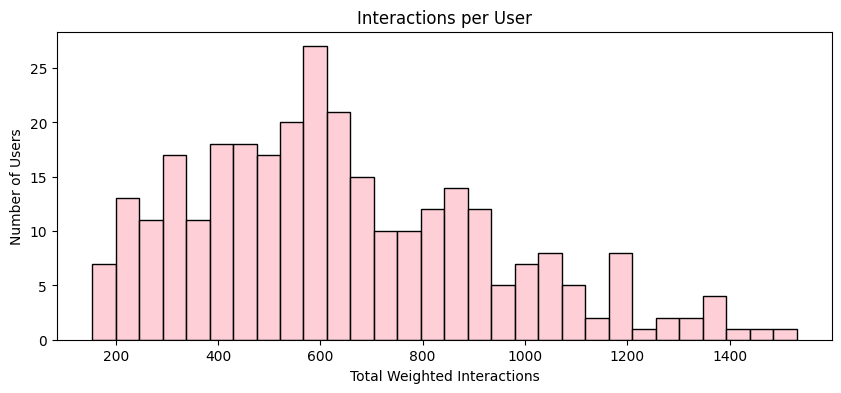

In [ ]:
# Matrix diagnostics & Sparsity Visualization
# Diagnostics: User/Product Activity stats

import matplotlib.pyplot as plt
import seaborn as sns

# 1 - Total interactions per user
user_activity = interaction_matrix.sum(axis=1).A1
plt.figure(figsize=(10, 4))
sns.histplot(user_activity, bins=30, kde=False, color='pink')
plt.title("Interactions per User")
plt.xlabel("Total Weighted Interactions")
plt.ylabel("Number of Users")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

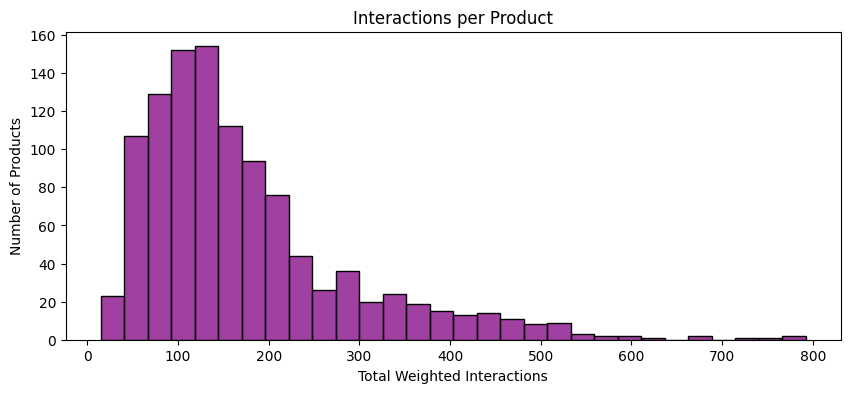

In [ ]:
# 2 - Total interactions per product
product_activity = interaction_matrix.sum(axis=0).A1
plt.figure(figsize=(10, 4))
sns.histplot(product_activity, bins=30, kde=False, color='purple')
plt.title("Interactions per Product")
plt.xlabel("Total Weighted Interactions")
plt.ylabel("Number of Products")
plt.show

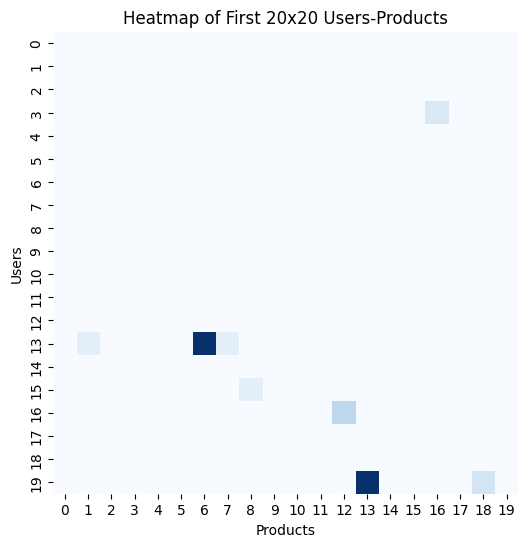

In [ ]:
# Sparsity heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(interaction_matrix[:20, :20].toarray(), cmap="Blues", cbar=False)
plt.title("Heatmap of First 20x20 Users-Products")
plt.xlabel("Products")
plt.ylabel("Users")
plt.show()

In [ ]:
# ───────────────────────────────────────────────────────────
# ①  Train–Test Split  (reproducible 80/20 leave-one-out)
# ───────────────────────────────────────────────────────────
import random
from scipy.sparse import csr_matrix, lil_matrix

random.seed(42)                       # reproducible split

interaction_lil = interaction_matrix.tolil()          # full user×item
test_matrix     = lil_matrix(interaction_matrix.shape)

for u in range(interaction_matrix.shape[0]):
    items = interaction_matrix[u].nonzero()[1]
    if len(items) >= 2:
        test_item = random.choice(items)              # hold-out ONE item
        test_matrix[u, test_item]  = interaction_matrix[u, test_item]
        interaction_lil[u, test_item] = 0             # remove from train

train_matrix = interaction_lil.tocsr()
test_matrix  = test_matrix.tocsr()

print("Train:", train_matrix.shape, "| non-zeros:", train_matrix.count_nonzero())
print("Test :",  test_matrix.shape,  "| non-zeros:", test_matrix.count_nonzero())


Train: (300, 1100) | non-zeros: 14872
Test : (300, 1100) | non-zeros: 300


In [ ]:
from tqdm.auto import tqdm
import numpy as np

def precision_at_k(model, user_item_conf, test_matrix, K=10):
    precisions = []
    for u in range(test_matrix.shape[0]):
        held_out = test_matrix[u].indices
        if not len(held_out):
            continue

        user_row = user_item_conf[u]             # shape 1 × items

        recs = model.recommend(
            userid=u,
            user_items=user_row,
            N=K,
            filter_already_liked_items=True,
            recalculate_user=True
        )
        rec_ids = recs[0] if isinstance(recs, tuple) else [i for i,_ in recs]
        precisions.append(len(np.intersect1d(held_out, rec_ids)) / K)

    return np.mean(precisions) if precisions else 0.0


In [ ]:
alpha = 40
conf_matrix     = train_matrix * alpha          # user×item
item_user_conf  = conf_matrix.T.tocsr()         # item×user

als = AlternatingLeastSquares(factors=50, regularization=0.05,
                              iterations=30, random_state=42)
als.fit(item_user_conf)                         # train

p10 = precision_at_k(als, item_user_conf, test_matrix, K=10)
print("Precision@10:", p10)


/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/30 [00:00<?, ?it/s]

Precision@10: 0.0006666666666666668


In [ ]:
# ── Extended grid search including alpha ──
from itertools import product
import pandas as pd
from tqdm.auto import tqdm
from implicit.als import AlternatingLeastSquares

alpha_list = [10, 20, 40, 80]    # try a range of confidence multipliers
param_grid = {
    "alpha":          alpha_list,
    "factors":        [20, 50, 100, 150],
    "regularization": [1e-4, 1e-3, 0.005, 0.01],
    "iterations":     [15, 30],
}

results = []
for alpha_val, f, reg, iters in tqdm(list(product(
        param_grid["alpha"],
        param_grid["factors"],
        param_grid["regularization"],
        param_grid["iterations"]
))):
    # rebuild confidence matrices for this alpha
    conf      = train_matrix * alpha_val
    item_conf = conf.T.tocsr()

    # train ALS
    m = AlternatingLeastSquares(
        factors        = f,
        regularization = reg,
        iterations     = iters,
        random_state   = 42
    )
    m.fit(item_conf)

    # evaluate — use item_conf, not the old item_user_conf
    p10 = precision_at_k(als, item_user_conf, test_matrix, K=10)

    results.append({
        "alpha":           alpha_val,
        "factors":         f,
        "regularization":  reg,
        "iterations":      iters,
        "precision@10":    round(p10, 4)
    })
# summarize
grid_df = pd.DataFrame(results)
grid_df = grid_df.sort_values("precision@10", ascending=False)
display(grid_df.head(10))

best = grid_df.iloc[0]
print("Best settings:", dict(best))


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

,alpha,factors,regularization,iterations,precision@10
0,10,20,0.0001,15,0.0003
1,10,20,0.0001,30,0.0003
2,10,20,0.0010,15,0.0003
3,10,20,0.0010,30,0.0003
4,10,20,0.0050,15,0.0003
5,10,20,0.0050,30,0.0003
6,10,20,0.0100,15,0.0003
7,10,20,0.0100,30,0.0003
8,10,50,0.0001,15,0.0003
9,10,50,0.0001,30,0.0003


Best settings: {'alpha': np.float64(10.0), 'factors': np.float64(20.0), 'regularization': np.float64(0.0001), 'iterations': np.float64(15.0), 'precision@10': np.float64(0.0003)}


In [ ]:
# ── Train ALS with the grid-search best params ──
alpha = 10

conf_matrix    = train_matrix * alpha    # user × item
item_user_conf = conf_matrix.T.tocsr()   # item × user  ← train on this

als = AlternatingLeastSquares(
    factors        = 20,
    regularization = 1e-4,
    iterations     = 15,
    random_state   = 42
)
als.fit(item_user_conf)

p10 = precision_at_k(als, item_user_conf, test_matrix, K=10)
print("Precision@10:", p10)


  0%|          | 0/15 [00:00<?, ?it/s]

Precision@10: 0.0003333333333333334


In [ ]:
# Heat-map
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# item_factors: (num_items × factors) matrix from ALS
item_factors = als_model.item_factors

# pairwise Pearson correlation between items
corr = np.corrcoef(item_factors)

plt.figure(figsize=(10, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    square=True,
    annot=True,
    fmt=".2f",
    xticklabels=[idx2product[i] for i in range(len(corr))],
    yticklabels=[idx2product[i] for i in range(len(corr))]
)
plt.title("Item-factor correlation (ALS)")
plt.tight_layout()
plt.show()


NameError: name 'als_model' is not defined

In [ ]:
# tag mapping for meta data
TAG_COLUMNS = ["product_type", "color", "material", "pattern", "season", "price_range"]

product_to_tags = {}
for _, row in df_products.iterrows():
    pid = row["product_id"]
    tag_set = set()
    for col in TAG_COLUMNS:
        tag_val = str(row[col]).strip().lower()
        tag_set.add(f"{col}_{tag_val}")
    product_to_tags[pid] = tag_set


In [ ]:
from collections import Counter

def tags_from_products(product_ids):
    all_tags = []
    for pid in product_ids:
        all_tags.extend(product_to_tags.get(pid, []))
    return Counter(all_tags)

In [ ]:
# Tag recommendation

def recommend_products_numeric(user_idx, k=5):
    # ALS top-k product IDs given an integer user index
    rec_ids, _ = als_model.recommend(
        userid=int(user_idx),
        user_items=train_matrix[int(user_idx)],
        N=k,
        filter_already_liked_items=True,
        recalculate_user=True
    )
    return [idx2product[i] for i in rec_ids]

def recommend_tags_numeric(user_idx, k_products=5, k_tags=5):
    # Top tags after aggregating from top products
    prods = recommend_products_numeric(user_idx, k=k_products)
    tag_counts = tags_from_products(prods)       # Counter of tags
    return tag_counts.most_common(k_tags)

while True:
    inp = input("\nEnter numeric user ID (or 'quit'): ").strip()
    if inp.lower() in {"quit", "exit"}:
        break
    if not inp.isdigit() or int(inp) >= train_matrix.shape[0]:
        print(" Please enter a valid numeric user index (0 –", train_matrix.shape[0]-1, ")")
        continue

    uid = int(inp)
    print(f"\n Recommendations for user {uid}")

    print(" Products:")
    for pid in recommend_products_numeric(uid, k=5):
        print("  •", pid)

    print(" Tags:")
    for tag, cnt in recommend_tags_numeric(uid, k_products=5, k_tags=5):
        print(f"  • {tag}  (score: {cnt})")



Enter numeric user ID (or 'quit'): 800

 Recommendations for user 800
 Products:
  • PID01770
  • PID01782
  • PID01772
  • PID01757
  • PID01780
 Tags:
  • price_range_3000-5500  (score: 3)
  • price_range_1500-3000  (score: 2)
  • season_second inter-monsoon  (score: 2)
  • product_type_shorts  (score: 1)
  • season_pre-avurudu heat  (score: 1)

Enter numeric user ID (or 'quit'): quit
